# Retail Sales Forecasting
Previsão de curto prazo para otimizar estoques na loja

#### Contexto
Este conjunto de dados contém muitos dados históricos de vendas. Ele foi extraído de um grande varejista brasileiro e tem muitos SKUs e muitas lojas. Os dados foram transformados para proteger a identidade do varejista.

## Importando bibliotecas

In [199]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

## Carregando dataset

In [200]:
url = 'https://raw.githubusercontent.com/MARINHOALEX/Retail-Sales-Forecasting/refs/heads/main/mock_kaggle.csv?token=GHSAT0AAAAAACZG45GCDYKQ2QX2CP5B6DWAZYUDKTA'

df = pd.read_csv(url)

display(df.head())
display(df.info())

,data,venda,estoque,preco
0,2014-01-01,0,4972,1.29
1,2014-01-02,70,4902,1.29
2,2014-01-03,59,4843,1.29
3,2014-01-04,93,4750,1.29
4,2014-01-05,96,4654,1.29


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 937 entries, 0 to 936
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     937 non-null    object 
 1   venda    937 non-null    int64  
 2   estoque  937 non-null    int64  
 3   preco    937 non-null    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 29.4+ KB


None

## Pré-Processamento

In [201]:
# Verificando de há valores nulos
print(df.isnull().sum())

data       0
venda      0
estoque    0
preco      0
dtype: int64


In [202]:
# Alterando tipo de data para datetime
df.data = pd.to_datetime(df['data'])

In [203]:
# Criando features temporais
df['ano'] = df['data'].dt.year
df['mes'] = df['data'].dt.month
df['dia_semana'] = df['data'].dt.dayofweek
df['semana_ano'] = df['data'].dt.isocalendar().week

## Analise exploratória

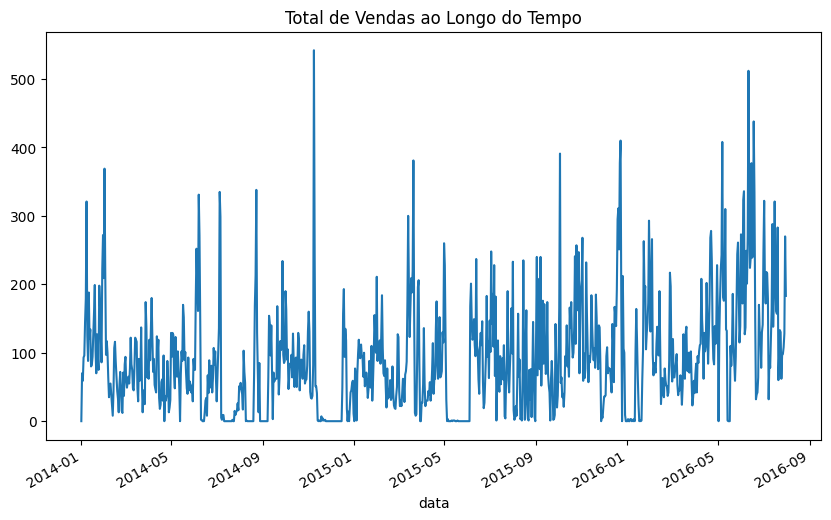

In [204]:
# Visualisando vendas ao longo do tempo
plt.figure(figsize=(10,6))
df.groupby('data')['venda'].sum().plot()
plt.title('Total de Vendas ao Longo do Tempo')
plt.show()


## Dividindo Dataset

In [205]:
# Verificando data minima e maxima para dividir por data
df.data.min(), df.data.max()

(Timestamp('2014-01-01 00:00:00'), Timestamp('2016-07-31 00:00:00'))

In [206]:
# Dividindo em 01/01/2016
train = df[df.data < '2015-01-01']
test = df[df.data >= '2015-01-01']

## Modelando Série Temporal

### Modelo Prophet

19:15:21 - cmdstanpy - INFO - Chain [1] start processing
19:15:21 - cmdstanpy - INFO - Chain [1] done processing



Mean Absolute Error (Prophet): 87.65162202515765
Mean Squared Error (Prophet): 11700.18977831679


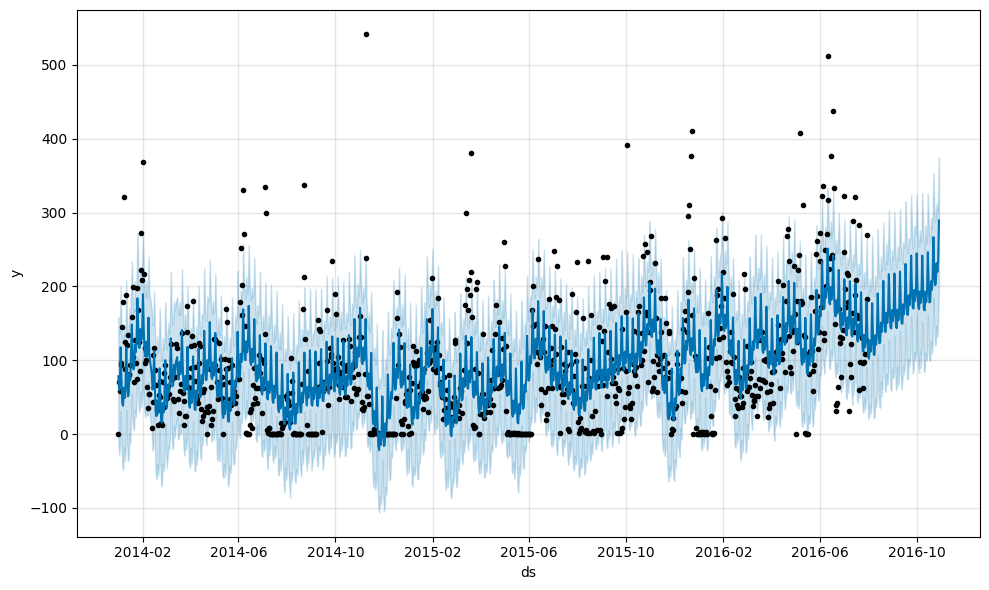

In [207]:
from prophet import Prophet

df_prophet = df[['data', 'venda']].rename(columns={'data': 'ds', 'venda': 'y'})

model = Prophet(yearly_seasonality=True, daily_seasonality=True)
model.fit(df_prophet)

future = model.make_future_dataframe(periods=90)
forecast = model.predict(future)

model.plot(forecast)

print()

# Avaliando mae e mse
predictions = forecast['yhat'][-90:].values
y_test_real = df_prophet['y'].values[-90:]

mae = mean_absolute_error(y_test_real, predictions)
print(f'Mean Absolute Error (Prophet): {mae}')

mse = mean_squared_error(y_test_real, predictions)
print(f'Mean Squared Error (Prophet): {mse}')

plt.show()

### Modelo XGBoostRegressor

Mean Absolute Error (XGBoost): 89.29932322387471


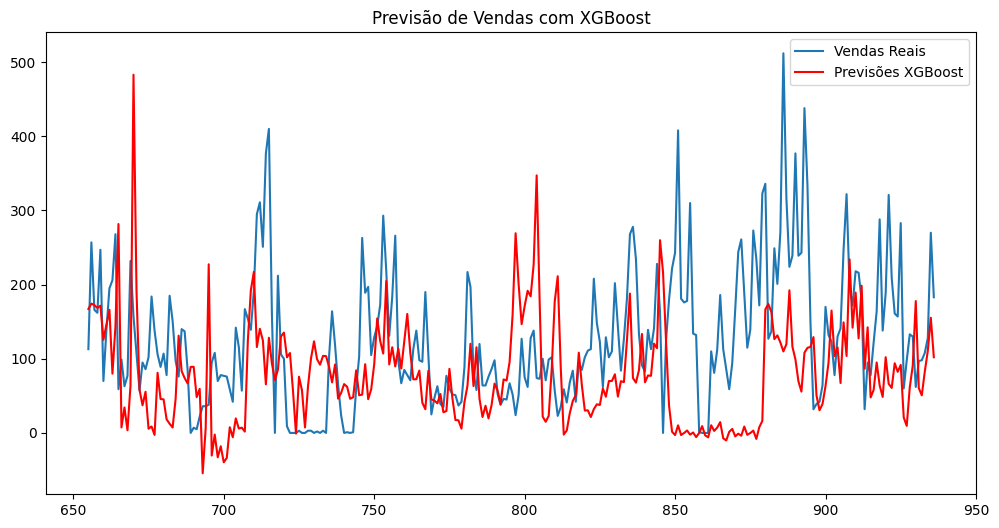

In [212]:
import xgboost as xgb

X = df[['ano', 'mes', 'dia']]
y = df['venda']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

model = xgb.XGBRegressor(objective='reg:squarederror')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error (XGBoost): {mae}')

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Vendas Reais')
plt.plot(y_test.index, y_pred, label='Previsões XGBoost', color='red')
plt.title('Previsão de Vendas com XGBoost')
plt.legend()
plt.show()


Modelo Tensorflow LSTM

Epoch 1/100


c:\Users\alexm\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0270
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0158
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0172
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0163
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0157
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0157
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0135
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0147
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0141
Epoch 10/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0147
Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0108
Epoch 12/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0136
Epoch 13/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0131
Epoch 14/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0127
Epoch 15/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0124
E

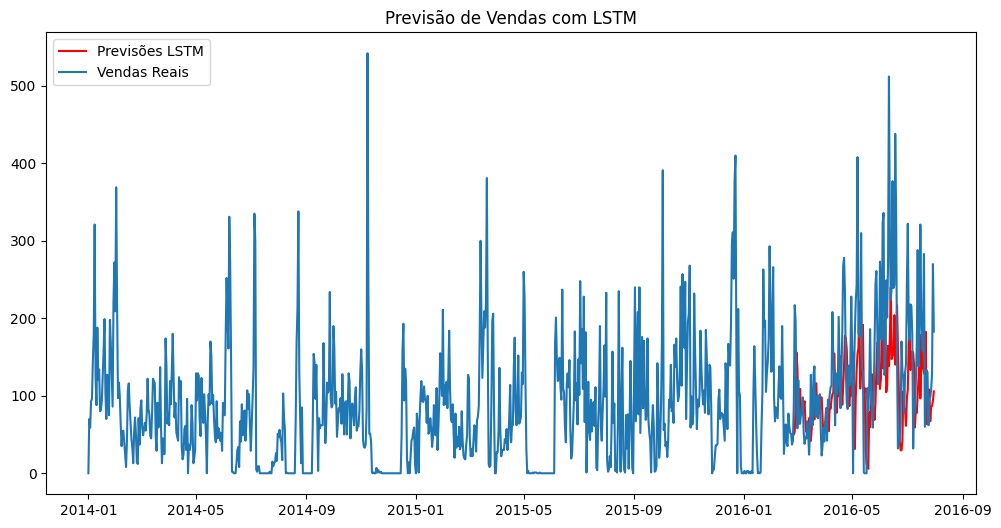

In [171]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

url = 'https://raw.githubusercontent.com/MARINHOALEX/Retail-Sales-Forecasting/refs/heads/main/mock_kaggle.csv?token=GHSAT0AAAAAACZG45GCDYKQ2QX2CP5B6DWAZYUDKTA'

df = pd.read_csv(url)

# Preparar os dados
df['data'] = pd.to_datetime(df['data'])  # Certifique-se de que a coluna de datas está em formato datetime
df.set_index('data', inplace=True)  # Definir a coluna de data como índice

# Normalizar os dados
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['venda'].values.reshape(-1, 1))

# Criar conjuntos de treino e teste
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Função para criar datasets para LSTM
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Criar datasets com um time step de 30 dias
time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape dos dados para [amostras, tempo, características]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Criar o modelo LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compilar o modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Treinar o modelo
model.fit(X_train, y_train, epochs=100, batch_size=32)

# Fazer previsões
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)  # Reverter a normalização

# Plotar as previsões
plt.figure(figsize=(12, 6))
plt.plot(df.index[train_size + time_step + 1:], predictions, label='Previsões LSTM', color='red')
plt.plot(df.index, df['venda'], label='Vendas Reais')
plt.title('Previsão de Vendas com LSTM')
plt.legend()
plt.show()


In [172]:
# Extrair os valores reais correspondentes das previsões
y_test_real = df['venda'].values[train_size + time_step + 1:len(df) - 1]

# Ajustar as previsões para que tenham o mesmo comprimento
predictions = predictions.flatten()[:len(y_test_real)]

# Calcular MAE
mae = mean_absolute_error(y_test_real, predictions)
print(f'Mean Absolute Error (LSTM): {mae}')

# Calcular MAPE
mape = np.mean(np.abs((y_test_real - predictions) / y_test_real)) * 100
print(f'Mean Absolute Percentage Error (LSTM): {mape}%')


Mean Absolute Error (LSTM): 68.27097693467752
Mean Absolute Percentage Error (LSTM): inf%


C:\Users\alexm\AppData\Local\Temp\ipykernel_17844\3078396411.py:12: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_test_real - predictions) / y_test_real)) * 100
